In [1]:
import requests
from dotenv import load_dotenv
import os
import json
import base64   
import pandas as pd
import librosa
import numpy as np
import lyricsgenius
import langdetect
import re
from joblib import Parallel, delayed
import string
from tqdm import tqdm
import tempfile
from datetime import datetime, timedelta
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor
from difflib import SequenceMatcher

c:\Users\wyero\AppData\Local\Programs\Python\Python39\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 10.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# For any api we can try using the "+" email trick to get more API keys

genius_client_id = "wZZ2RWc5mqp-5Pbz2W1rQJWE8LQ3pFBrb1Hw5_AOqgybq28mt7kjdjcG4zktCNbO"
genius_client_secret = "PefqBJHor_muDgTutGlaXXaxmzsI7TQCps9FQ3FwkUTT0WJIT3s0A5YA9mnFbfp_-CBhQF7b0omgE8kaM3dJ3w"
genius_access_token = "NUHHVpwnmbDYUYw8Padu0gQeHvYN4OsKYtE2MKNUpBUI6yR-xZXKY6S5NvCnFbiP"

lastfm_api_key = "97d5a64d5ba4a8bc580b752ceff3b87f"
lastfm_secret = "35175090bd61f6f16ac607bd26e5b1de"

In [3]:
base_url = 'http://ws.audioscrobbler.com/2.0/'

def lastfm_get(payload):
    headers = {'user-agent': 'DataCollectorBot'}
    payload['api_key'] = lastfm_api_key
    payload['format'] = 'json'
    response = requests.get(base_url, headers=headers, params=payload)
    return response.json()

# Function for each endpoint
def get_user_info(user):
    payload = {'method': 'user.getinfo', 'user': user}
    return lastfm_get(payload)

def get_top_albums(user):
    payload = {'method': 'user.gettopalbums', 'user': user}
    return lastfm_get(payload)

def get_top_artists(user):
    payload = {'method': 'user.gettopartists', 'user': user}
    return lastfm_get(payload)

def get_top_tracks(user):
    payload = {'method': 'user.gettoptracks', 'user': user}
    return lastfm_get(payload)



In [4]:
def list_to_df(data_list, columns):
    if data_list:
        df = pd.DataFrame(data_list, columns=columns)
        return df
    else:
        return pd.DataFrame(columns=columns)
    
def get_top_albums_df(user):
    result = get_top_albums(user)
    albums = []
    for item in result['topalbums']['album']:
        albums.append({
            'Rank': item['@attr']['rank'],
            'Album Name': item['name'],
            'Artist': item['artist']['name'],
            'Play Count': item['playcount']
        })
    return list_to_df(albums, ['Rank', 'Album Name', 'Artist', 'Play Count'])

def get_top_artists_df(user):
    result = get_top_artists(user)
    artists = []
    for item in result['topartists']['artist']:
        artists.append({
            'Rank': item['@attr']['rank'],
            'Artist': item['name'],
            'Play Count': item['playcount']
        })
    return list_to_df(artists, ['Rank', 'Artist', 'Play Count'])


def get_top_tracks_df(user):
    result = get_top_tracks(user)
    tracks = []
    for item in result['toptracks']['track']:
        tracks.append({
            'Rank': item['@attr']['rank'],
            'Track Name': item['name'],
            'Artist': item['artist']['name'],
            'Play Count': item['playcount']
        })
    return list_to_df(tracks, ['Rank', 'Track Name', 'Artist', 'Play Count'])

In [5]:
def get_combined_top_data(user, top_n=10):
    # Retrieve top albums, artists, and tracks dataframes limited to top_n entries
    top_albums_df = get_top_albums_df(user).head(top_n)
    top_artists_df = get_top_artists_df(user).head(top_n)
    top_tracks_df = get_top_tracks_df(user).head(top_n)
    
    # Make sure that the 'Rank' column is of the same data type across all DataFrames before concatenating
    top_albums_df['Rank'] = top_albums_df['Rank'].astype(int)
    top_artists_df['Rank'] = top_artists_df['Rank'].astype(int)
    top_tracks_df['Rank'] = top_tracks_df['Rank'].astype(int)

    # Align DataFrames by 'Rank' and horizontally concatenate
    combined_df = pd.concat([top_albums_df.set_index('Rank'),
                             top_artists_df.set_index('Rank'),
                             top_tracks_df.set_index('Rank')],
                            axis=1,
                            keys=['Albums', 'Artists', 'Tracks'])
    
    combined_df.reset_index(inplace=True)

    return combined_df



df2 = get_combined_top_data("Bans77")
df2

Rank                     Albums                             \
                       Album Name          Artist Play Count   
0    1        Discography, Vol. 1      VELVETEARS       2831   
1    2                   3 Ghosts      VELVETEARS       1477   
2    3             Думала ты одна     Даша Каплан       1456   
3    4  мои (твои) тёмные желания            ooes       1217   
4    5        Discography, Vol. 2      VELVETEARS       1009   
5    6             Pins & Needles      VELVETEARS        921   
6    7             Мне не страшно            ooes        748   
7    8                         22  Erika Lundmoen        699   
8    9                   Immunity          Clairo        688   
9   10                 Hikikomori      VELVETEARS        683   

               Artists                                 Tracks  \
                Artist Play Count                  Track Name   
0           VELVETEARS      10912              Думала ты одна   
1                 ooes       2730              Sincere Regret   
2               Clairo       2251                       Minor   
3        Alexis Munroe       1972                Central Park   
4              Grechka       1522                     nothing   
5          Даша Каплан       1457                      больше   
6     Maggie Lindemann       1384         Million Dollar Song   
7               Zheani       1077                    Imma Lie   
8              DSPRITE       1062            Will I Ever Care   
9  Side of Despondency       1053  We All Wanna Die Sometimes   

                                   
                Artist Play Count  
0          Даша Каплан       1457  
1  Side of Despondency        357  
2        Gracie Abrams        345  
3           VELVETEARS        291  
4           VELVETEARS        265  
5                 ooes        258  
6           VELVETEARS        255  
7           VELVETEARS        253  
8           VELVETEARS        251  
9           VELVETEARS        243

# Audio


In [3]:
import pandas as pd
from ast import literal_eval


def safe_eval(x):
    try:
        return literal_eval(x)
    except:
        return x
    
def preprocess_column(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: [] if pd.isna(x) or x == "" else x)
    df[column_name] = df[column_name].apply(safe_eval)
    return df

def extract_unique_songs(df):
    # Preprocess 'Top 50 Songs' and 'Liked Songs' columns
    df = preprocess_column(df, 'Top 50 Songs')
    df = preprocess_column(df, 'Liked Songs')
    
    all_songs = []
    for index, row in df.iterrows():
        if isinstance(row['Top 50 Songs'], list) and isinstance(row['Liked Songs'], list):
            all_songs.extend(row['Top 50 Songs'])
            all_songs.extend(row['Liked Songs'])
    
    unique_songs = list(set(all_songs))
    unique_songs_df = pd.DataFrame(unique_songs, columns=['Unique Songs'])
    
    # Export the DataFrame to an Excel file
    unique_songs_df.to_excel("Unique_songs.xlsx", index=False)
    
    return unique_songs_df

In [4]:
def similar(a, b):
    """Calculate the similarity score between two strings using SequenceMatcher."""
    return SequenceMatcher(None, a, b).ratio()

def get_highest_similarity_track(tracks, track_name):

    track_similarities = [(track, similar(track_name, track['title'])) for track in tracks]

    best_match, highest_similarity = max(track_similarities, key=lambda x: x[1], default=(None, 0))

    if best_match and highest_similarity > 0.4:  
        return best_match['id']
    return None

def search_deezer_track(track_name, artist_name):
    search_url = "https://api.deezer.com/search/track"
    query = f"{track_name} artist:\"{artist_name}\""
    params = {"q": query}
    try:
        response = requests.get(search_url, params=params)
        response.raise_for_status()
        tracks = response.json().get('data', [])
        if tracks:
            # Use the optimized method to find the highest similarity track
            # best_match_id = get_highest_similarity_track(tracks, track_name)
            # return best_match_id
            return tracks[0]['id']
        return None
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return None
    
def get_deezer_track_info(track_id):
    if not track_id:
        return {}
    base_url = "https://api.deezer.com/track/"
    try:
        response = requests.get(f"{base_url}{track_id}")
        response.raise_for_status()
        data = response.json()

        main_artist = data.get("artist", {}).get("name", "")
        contributors = [contributor['name'] for contributor in data.get("contributors", []) if contributor['name'] != main_artist]
        featured_artists = ", ".join(contributors) if contributors else None

        return {
            "title": data.get("title"),
            "artist": main_artist,
            "featured_artists": featured_artists,
            "duration": data.get("duration"),
            "album": data.get("album", {}).get("title"),
            "preview_url": data.get("preview"),
            "link": data.get("link")
        }
    except requests.RequestException:
        return {}

In [5]:
def extract_librosa_features_from_url(url):
    # Fetch the audio file from the URL
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download audio file from {url}")
    
    # Create a temporary file and manually manage it
    temp_dir = tempfile.gettempdir()
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".mp3", dir=temp_dir)
    temp_file_path = temp_file.name
    
    try:
        # Write the fetched content to the temp file and close it to release the lock
        temp_file.write(response.content)
        temp_file.close()
        
        y, sr = librosa.load(temp_file_path, sr=None)  # Using sr=None to preserve the original sampling rate
        
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        rms = np.mean(librosa.feature.rms(y=y))
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))


        features = {
            'mfcc': np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis=0),
            'chroma': np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0),
            'rms': rms,
            'spectral_centroid': spectral_centroid,
            'zcr': zcr,
            'tempo': tempo
        }
    finally:
        os.remove(temp_file_path)

    return features

In [40]:
def estimate_danceability(features):
    beat_intervals = np.diff(features['beat_times'])
    beat_interval_std = np.std(beat_intervals)
    # Lower standard deviation in beat intervals indicates more consistent rhythm
    rhythmic_stability = 1 - (beat_interval_std / (np.mean(beat_intervals) + 1e-6))
    tempo_confidence = features.get('tempo_confidence', 0.5)  # Assuming a placeholder value if not provided
    return np.mean([rhythmic_stability, tempo_confidence, np.mean(features['chroma'])])

def estimate_loudness(features):
    # Convert RMS to a dB scale for a more perceptual loudness measurement
    rms_db = 20 * np.log10(features['rms'] + 1e-6)
    # Map the dB scale to a 0-1 range considering human hearing sensitivity
    return np.interp(rms_db, [-60, 0], [0, 1])



def calculate_song_features(features):
    scores = {}

    # Danceability
    scores['danceability'] = estimate_danceability(features)

    # Loudness
    scores['loudness'] = estimate_loudness(features)

    return scores

In [6]:
def process_song(track_name, artist_name):
    # Use both track_name and artist_name for searching
    track_id = search_deezer_track(track_name, artist_name)  # Update this function as needed to use both parameters
    track_info = get_deezer_track_info(track_id)
    if not track_info or 'preview_url' not in track_info or not track_info['preview_url']:
        return {'Song': track_name, 'Artist': artist_name}  # Return minimal data if track info is not available or no preview URL

    try:
        features = extract_librosa_features_from_url(track_info['preview_url'])
        # scores = calculate_song_features(features)
    except Exception as e:
        print(f"Error processing {track_name}: {e}")
        features = {}
        scores = {}

    # Merge dictionaries: track_info, features, and scores.
    return {**{'Song': track_name, 'Artist': artist_name}, **track_info, **features} # Add **scores if we using the calculate_song_features


In [7]:
def main(df_songs):
    # Filter rows where 'mfcc' column is null, indicating missing features
    df_songs = df_songs[df_songs['mfcc'].isnull()]
    
    # Convert DataFrame rows to a list of tuples for iteration
    tracks_and_artists = [(row['track_name_original'], row['artist_name_original']) for index, row in df_songs.iterrows()]
    
    # Initialize the ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=20) as executor:
        # Submit all tasks to the executor
        future_to_song = {executor.submit(process_song, track, artist): (track, artist) for track, artist in tracks_and_artists}
        
        # Initialize a list to accumulate results
        results = []
        
        # Use tqdm to display progress
        for future in tqdm(as_completed(future_to_song), total=len(tracks_and_artists), desc="Processing Songs"):
            track, artist = future_to_song[future]
            try:
                song_data = future.result()
                results.append(song_data)
            except Exception as e:
                print(f"Error processing {track} by {artist}: {e}")
    
    # Convert the accumulated results into a DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_excel("../../Downloads/Impute1.xlsx", index=False)


try_df = pd.read_excel("../../Downloads/BT4222ProjectExcel/unique_songs_audio_hasnull.xlsx")
# try_df = try_df[['track_name_original', 'artist_name_original']]
main(try_df[:100000])


Processing Songs:   2%|▏         | 895/46790 [21:07<18:03:03,  1.42s/it]


Explained variance ratio of each component: [8.39387642e-01 6.57352756e-02 3.43895288e-02 1.86747653e-02
 9.91152810e-03 7.01359114e-03 6.07220406e-03 3.73449368e-03
 2.95219624e-03 2.43605921e-03 1.78367960e-03 1.55408120e-03
 1.31653317e-03 1.14327846e-03 9.21914541e-04 7.71835301e-04
 7.04086308e-04 5.92760296e-04 5.44679317e-04 3.59867338e-04]


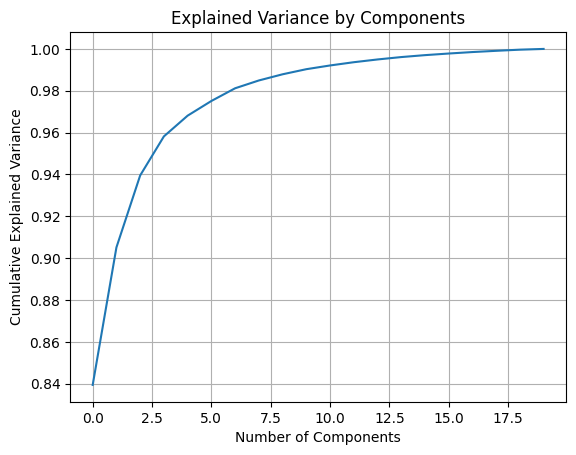

In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import ast
def parse_array(s):
    if pd.isna(s):
        return np.array([])  
    numbers = s.strip("[]").split()  
    return np.array([float(num) for num in numbers])


df = pd.read_excel("../../Downloads/ReRun7.xlsx")
df = df[["mfcc", "chroma", "rms", "spectral_centroid", "zcr", "tempo"]]
pca = PCA()
df = df.dropna(subset=['mfcc', 'chroma', 'rms', 'spectral_centroid', 'zcr', 'tempo'])
df['mfcc'] = df['mfcc'].apply(parse_array)

df['mfcc'] = df['mfcc'].apply(lambda x: np.array(x))

df['mfcc'] = df['mfcc'].apply(lambda x: x.flatten())

X = np.stack(df['mfcc'].values, axis=0)

pca = PCA()
X_pca = pca.fit_transform(X)

print("Explained variance ratio of each component:", pca.explained_variance_ratio_)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

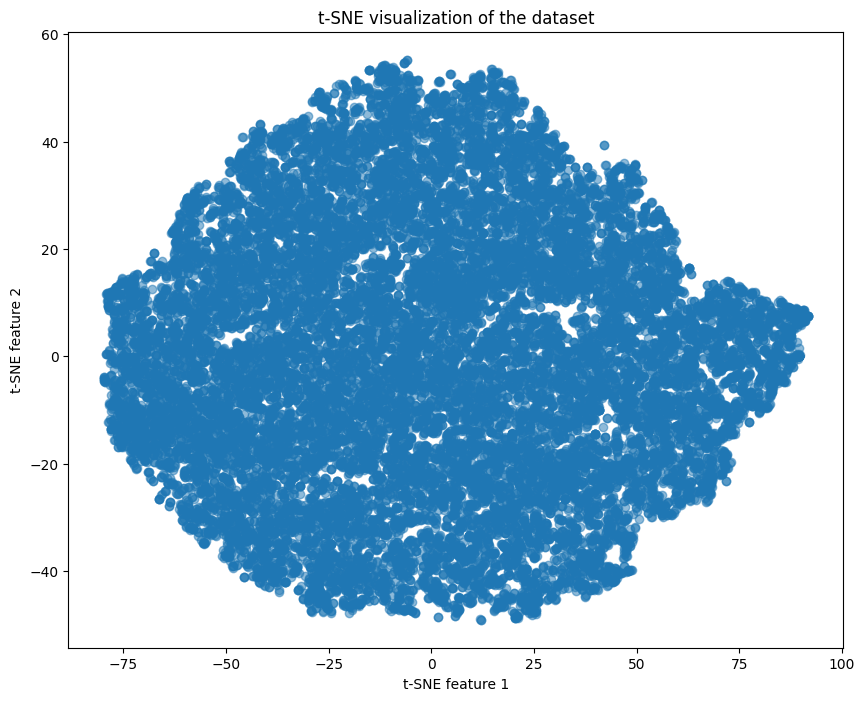

In [53]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
def parse_array(s):
    if pd.isna(s):
        return np.array([])  
    numbers = s.strip("[]").split()  
    return np.array([float(num) for num in numbers])


df = pd.read_excel("../../Downloads/ReRun7.xlsx")
df = df[["mfcc", "chroma", "rms", "spectral_centroid", "zcr", "tempo"]]
df = df.dropna(subset=['mfcc', 'chroma', 'rms', 'spectral_centroid', 'zcr', 'tempo'])
df['mfcc'] = df['mfcc'].apply(parse_array)

df['mfcc'] = df['mfcc'].apply(lambda x: np.array(x))

df['mfcc'] = df['mfcc'].apply(lambda x: x.flatten())

X = np.stack(df['mfcc'].values, axis=0)
X_tsne = tsne.fit_transform(X)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)
plt.title('t-SNE visualization of the dataset')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


c:\Users\wyero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


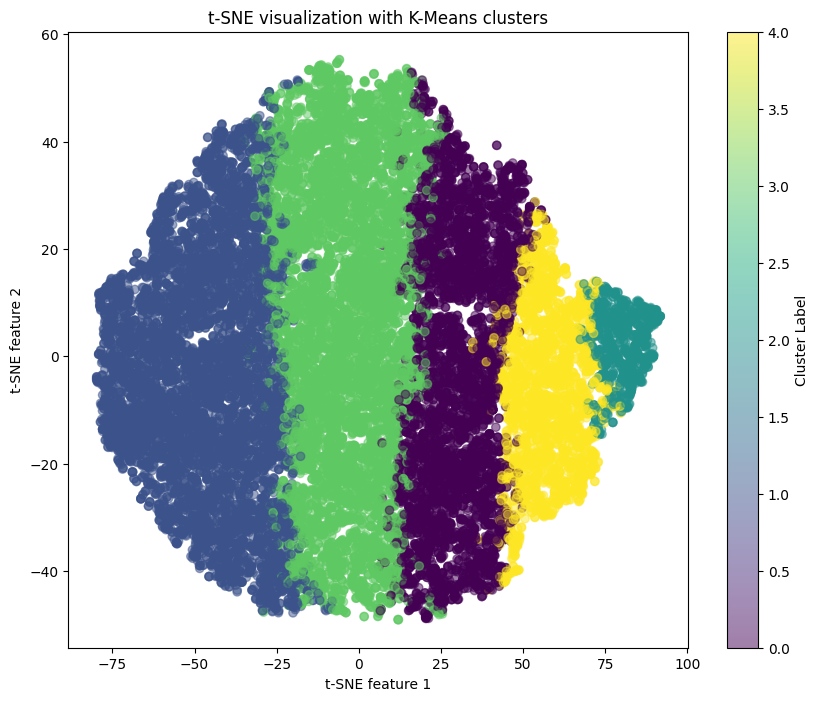

In [57]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, alpha=0.5, cmap='viridis')
plt.title('t-SNE visualization with K-Means clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar(label='Cluster Label')
plt.show()
